In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

from scipy.spatial.distance import cdist

import joblib
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics  import silhouette_score
set_config(display="diagram")

In [3]:
data = pd.read_csv("../data/final_data.csv", index_col=0)
data["id"] = np.array(data.index) + 1
data.head(5)

,brand,img_url,laptop_name,display_size,processor_type,graphics_card,disk_space,discount_price,ratings_5max,disk_type,id
0,HP,https://encrypted-tbn0.gstatic.com/images?q=tb...,Notebook 14-df0008nx,14.0,Intel Celeron N4000,Intel HD Graphics 600,64.0,1259.0,0.0,eMMC,1
1,Lenovo,https://encrypted-tbn0.gstatic.com/images?q=tb...,IdeaPad 330S-14IKB,14.0,Intel Core i5-8250U,Intel UHD Graphics 620,1024.0,1849.0,3.3,HDD,2
2,Huawei,https://encrypted-tbn0.gstatic.com/images?q=tb...,MateBook D Volta,14.0,Intel Core i5-8250U,NVIDIA GeForce MX150 (2 GB),256.0,2999.0,0.0,SSD,3
3,Dell,https://encrypted-tbn0.gstatic.com/images?q=tb...,Inspiron 15 3567,15.6,Intel Core i3-7020U,Intel HD Graphics 620,1024.0,1849.0,0.0,HDD,4
4,Asus,https://encrypted-tbn0.gstatic.com/images?q=tb...,VivoBook 15 X510UR,15.6,Intel Core i7-8550U,NVIDIA GeForce 930MX (2 GB),1024.0,2499.0,0.0,HDD,5


In [4]:
data['display_size'].value_counts()

15.60    82
14.00    49
13.30    48
15.40     9
13.00     3
13.50     3
17.30     3
13.88     2
12.00     2
13.90     1
18.40     1
Name: display_size, dtype: int64

# Creating Pipeline for Recommendation System 

In [75]:
data_for_recommendation = data.drop(["img_url", "laptop_name"], axis=1)
data_for_recommendation.head()

,brand,display_size,processor_type,graphics_card,disk_space,discount_price,ratings_5max,disk_type
0,HP,14.0,Intel Celeron N4000,Intel HD Graphics 600,64.0,1259.0,0.0,eMMC
1,Lenovo,14.0,Intel Core i5-8250U,Intel UHD Graphics 620,1024.0,1849.0,3.3,HDD
2,Huawei,14.0,Intel Core i5-8250U,NVIDIA GeForce MX150 (2 GB),256.0,2999.0,0.0,SSD
3,Dell,15.6,Intel Core i3-7020U,Intel HD Graphics 620,1024.0,1849.0,0.0,HDD
4,Asus,15.6,Intel Core i7-8550U,NVIDIA GeForce 930MX (2 GB),1024.0,2499.0,0.0,HDD


In [88]:
list(enumerate(data.columns))

[(0, 'brand'),
 (1, 'img_url'),
 (2, 'laptop_name'),
 (3, 'display_size'),
 (4, 'processor_type'),
 (5, 'graphics_card'),
 (6, 'disk_space'),
 (7, 'discount_price'),
 (8, 'ratings_5max'),
 (9, 'disk_type')]

In [122]:
pipeline = Pipeline([
    ("tnf1", ColumnTransformer([    
        ("one_hot_encoding", OneHotEncoder(dtype="int", sparse_output=False, handle_unknown="ignore"), [0,4,5,6,9]),
        ("scaling", MinMaxScaler(), [3, 7, 8]),
    ], remainder="drop"))
])
pipeline.fit(data_for_recommendation.values)

Pipeline(steps=[('tnf1',
                 ColumnTransformer(transformers=[('one_hot_encoding',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [0, 6, 9]),
                                                 ('scaling', MinMaxScaler(),
                                                  [3, 7, 8]),
                                                 ('ordinal', OrdinalEncoder(),
                                                  [4, 5])]))])

In [123]:
x = pipeline.transform([["HP","url", "dummy_laptop", 14.0, "Intel Celeron N4000", "NVIDIA GeForce MX150 (2 GB)", 64.0, 2344.0, 2.5, "SSD"]])[0]
x

array([ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.3125    ,  0.12456897,
        0.5       ,  4.        , 44.        ])

In [124]:
data_for_recommendation = pipeline.transform(data.values)
data_for_recommendation.shape

(203, 28)

Finding the optimal number of clusters using the silhoutter scores.

In [125]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 100)
for k in tqdm(K):
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, n_init="auto").fit(data_for_recommendation)
    kmeanModel.fit(data_for_recommendation)
  
    distortion = sum(np.min(cdist(data_for_recommendation, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / data_for_recommendation.shape[0]
    distortions.append(distortion)
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = distortion
    mapping2[k] = kmeanModel.inertia_

pd.DataFrame([pd.Series(mapping1, name="Distortions"), pd.Series(mapping2, name="Inertias")]).T

100%|█████████████████████████████████████████████████████████| 99/99 [00:02<00:00, 38.29it/s]


,Distortions,Inertias
1,13.974678,50027.993112
2,8.859604,18008.359027
3,6.093381,9197.680881
4,5.184810,6377.199404
5,4.787381,5434.363579
...,...,...
95,0.541463,97.876062
96,0.537047,92.772919
97,0.528920,90.568368
98,0.529813,90.721667


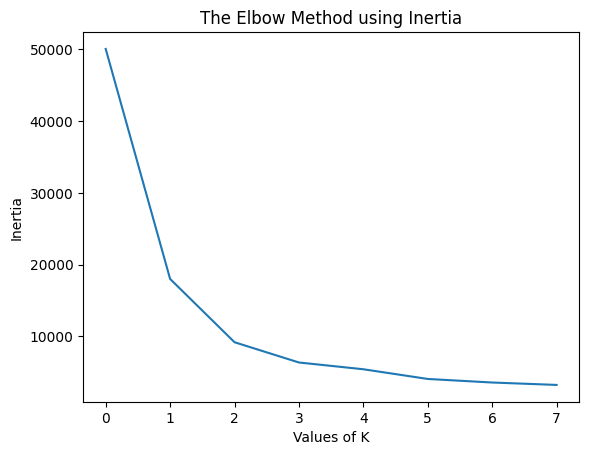

In [131]:
sns.lineplot(inertias[:8])
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [32]:
# silhouette_scores = []
# for n_clusters in range(2, 9):
#     kmeans = KMeans(n_clusters=n_clusters, n_init="auto")
#     cluster_labels = kmeans.fit_predict(data_for_recommendation)
#     silhouette_scores.append(silhouette_score(data_for_recommendation, cluster_labels))

# optimal_n_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
# print(f"The optimal number of clusters is {optimal_n_clusters}")

## Adding KMeans model to the pipeline

In [33]:
model = KMeans(n_clusters=3, n_init="auto")
model.fit(data_for_recommendation)
pipeline.steps.append(("estimator", model))
pipeline

Pipeline(steps=[('tnf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encoding',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [0, 7]),
                                                 ('scaling', StandardScaler(),
                                                  [1, 5, 6]),
                                                 ('ordinal_encoding',
                                                  OrdinalEncoder(),
                                                  [2, 3, 4])])),
                ('estimator', KMeans(n_clusters=3, n_init='auto'))])

In [34]:
data_for_recommendation = data.drop(["img_url", "laptop_name"], axis=1)
data["cluster"] = pipeline.predict(data_for_recommendation.values)
data.head()

,brand,img_url,laptop_name,display_size,processor_type,graphics_card,disk_space,discount_price,ratings_5max,disk_type,cluster
0,HP,https://encrypted-tbn0.gstatic.com/images?q=tb...,Notebook 14-df0008nx,14.0,Intel Celeron N4000,Intel HD Graphics 600,64.0,1259.0,0.0,eMMC,1
1,Lenovo,https://encrypted-tbn0.gstatic.com/images?q=tb...,IdeaPad 330S-14IKB,14.0,Intel Core i5-8250U,Intel UHD Graphics 620,1024.0,1849.0,3.3,HDD,0
2,Huawei,https://encrypted-tbn0.gstatic.com/images?q=tb...,MateBook D Volta,14.0,Intel Core i5-8250U,NVIDIA GeForce MX150 (2 GB),256.0,2999.0,0.0,SSD,2
3,Dell,https://encrypted-tbn0.gstatic.com/images?q=tb...,Inspiron 15 3567,15.6,Intel Core i3-7020U,Intel HD Graphics 620,1024.0,1849.0,0.0,HDD,0
4,Asus,https://encrypted-tbn0.gstatic.com/images?q=tb...,VivoBook 15 X510UR,15.6,Intel Core i7-8550U,NVIDIA GeForce 930MX (2 GB),1024.0,2499.0,0.0,HDD,0


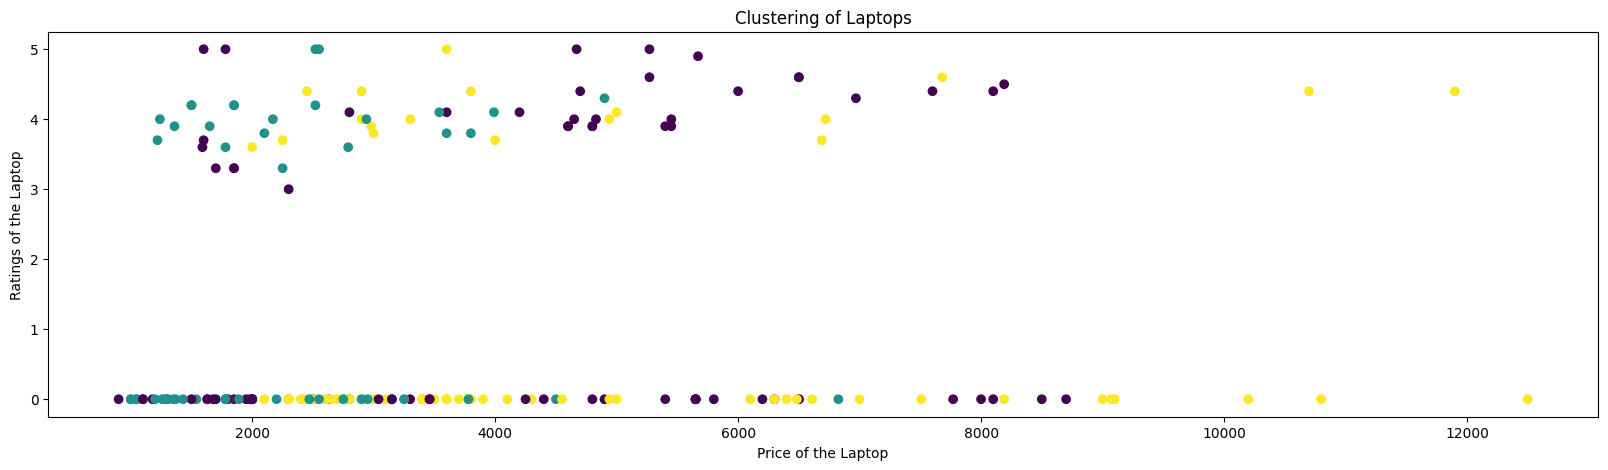

In [35]:
plt.figure(figsize=(20,5))
plt.scatter(x=data['discount_price'],y=data['ratings_5max'],c=data['cluster'])
plt.xlabel("Price of the Laptop")
plt.ylabel("Ratings of the Laptop")
plt.title("Clustering of Laptops")
plt.show()

### Recommending the laptop based on user preferences.
For example : if user prefers's a laptop with a 14 inch screen size, an above 3-star rating and disk space of atleast 32GB.

Creating a user preference dataframe.

In [36]:
user_pref = pd.DataFrame({
    "brand": ["HP"],
    "display_size": [15.6],
    "processor_type": ["Intel Celeron N4000"],
    "graphics_card": ["Intel HD Graphics 600"],
    "disk_space": [1024.0],
    "discount_price": [2000.0],
    "ratings_5max": [4.0],
    "disk_type": ["eMMC"]
})

user_pref

,brand,display_size,processor_type,graphics_card,disk_space,discount_price,ratings_5max,disk_type
0,HP,15.6,Intel Celeron N4000,Intel HD Graphics 600,1024.0,2000.0,4.0,eMMC


### Predicting the cluster the user's preferences belongs to

In [37]:
cluster = pipeline.predict(user_pref.values)[0]
cluster

1

### Recommending the laptops based on user's preference.

In [38]:
recommended_laptops = data[data['cluster'] == cluster]
recommended_laptops.head()

,brand,img_url,laptop_name,display_size,processor_type,graphics_card,disk_space,discount_price,ratings_5max,disk_type,cluster
0,HP,https://encrypted-tbn0.gstatic.com/images?q=tb...,Notebook 14-df0008nx,14.0,Intel Celeron N4000,Intel HD Graphics 600,64.0,1259.0,0.0,eMMC,1
5,Dell,https://encrypted-tbn0.gstatic.com/images?q=tb...,Vostro 5471,14.0,Intel Core i7-8550U,AMD Radeon 530 (4 GB),128.0,3799.0,3.8,HDD,1
9,HP,https://encrypted-tbn0.gstatic.com/images?q=tb...,14-cf0007nx,14.0,Intel Core i5-8250U,AMD Radeon 530 (2 GB),16.0,2629.0,0.0,HDD,1
10,HP,https://encrypted-tbn0.gstatic.com/images?q=tb...,15-db0001nx,15.6,AMD A9-9425,AMD Radeon R5,1024.0,1999.0,0.0,HDD,1
11,Acer,https://encrypted-tbn0.gstatic.com/images?q=tb...,Swift 5,14.0,Intel Core i7-8565U,Intel GMA HD,512.0,4499.0,0.0,SSD,1


# Making the Recommender Class

In [5]:
list(enumerate(data.columns))

[(0, 'brand'),
 (1, 'img_url'),
 (2, 'laptop_name'),
 (3, 'display_size'),
 (4, 'processor_type'),
 (5, 'graphics_card'),
 (6, 'disk_space'),
 (7, 'discount_price'),
 (8, 'ratings_5max'),
 (9, 'disk_type'),
 (10, 'id')]

In [10]:
class Recommender(Pipeline):
  def __init__(self, data, steps):
    self.data = data               # copy of the entire data
    super().__init__(steps)        # creating pipeline

    # fit
  def fit(self, X=None, y=None, **fit_params):
    data_fr = self.drop_cols().values
    return super().fit(data_fr)
  
    # return data
  def drop_cols(self):
    cols = ["id"]
    if "clusters" in data.columns:
        cols.append("clusters")
    return self.data.drop(cols, axis=1)
    

    # Predict clusters and add it as "clusters" column in the data
    # return the new data
  def make_clusters(self):
    self.data["clusters"] = self.predict(self.drop_cols().values)
    return self.data
  
    # get the cluster a user's data belongs to
  def get_cluster(self, user_pref):
    return super().predict([user_pref.values])[0]
  
    # get 'k' recommendations based on user's data
  def get_k_recommendations(self, user_pref, k=5):
    cluster = self.get_cluster(user_pref)
    return self.data[self.data["clusters"] == cluster].head(k)

# dummy data
user_pref = pd.Series({
    "brand": "HP",
    "image_url": "dummy_url.com",
    "laptop_name": "laptop_dummy",
    "display_size": 15.6,
    "processor_type": "Intel Celeron N4000",
    "graphics_card": "Intel HD Graphics 600",
    "disk_space": 1024.0,
    "discount_price": 2000.0,
    "ratings_5max": 4.0,
    "disk_type": "eMMC"
})
preprocessor = ColumnTransformer([    
    ("one_hot_encoding", OneHotEncoder(dtype="int", sparse_output=False, handle_unknown="ignore"), [0,6,9]),
    ("scaling", MinMaxScaler(), [3, 7, 8]),
    ("ordinal", OrdinalEncoder(), [4, 5])
], remainder="drop")

model = KMeans(n_clusters=11, n_init="auto")
recommender = Recommender(data.copy(), [
    ("preprocessing", preprocessor),
    ("model", model)
])

print("User's current laptop: ", user_pref, sep='\n')
recommender.fit()
recommender.make_clusters().head()
recommender.get_k_recommendations(user_pref)

User's current laptop: 
brand                                HP
image_url                 dummy_url.com
laptop_name                laptop_dummy
display_size                       15.6
processor_type      Intel Celeron N4000
graphics_card     Intel HD Graphics 600
disk_space                       1024.0
discount_price                   2000.0
ratings_5max                        4.0
disk_type                          eMMC
dtype: object


,brand,img_url,laptop_name,display_size,processor_type,graphics_card,disk_space,discount_price,ratings_5max,disk_type,id,clusters
0,HP,https://encrypted-tbn0.gstatic.com/images?q=tb...,Notebook 14-df0008nx,14.0,Intel Celeron N4000,Intel HD Graphics 600,64.0,1259.0,0.0,eMMC,1,3
10,HP,https://encrypted-tbn0.gstatic.com/images?q=tb...,15-db0001nx,15.6,AMD A9-9425,AMD Radeon R5,1024.0,1999.0,0.0,HDD,11,3
42,Apple,https://encrypted-tbn0.gstatic.com/images?q=tb...,MacBook,12.0,Intel Core M3,Intel HD Graphics 615,256.0,5269.0,5.0,SSD,43,3
62,Lenovo,https://encrypted-tbn0.gstatic.com/images?q=tb...,IdeaPad S145,15.6,Intel Celeron 4205U,Intel GMA HD,500.0,1039.0,0.0,HDD,63,3
81,Acer,https://encrypted-tbn0.gstatic.com/images?q=tb...,Aspire 3 A315-33-C6S9,15.6,Intel Celeron N3060,Intel GMA HD,500.0,1219.0,3.7,HDD,82,3


In [59]:
from sklearn.metrics.pairwise import cosine_similarity
feature = "15.6"
col = "display_size"
pivot_data = recommender.data.pivot(index=col, columns="id", values="ratings_5max").fillna(0)

In [60]:
pivot_data

id,1,2,3,4,5,6,7,8,9,10,...,194,195,197,198,199,200,201,202,203,204
display_size,,,,,,,,,,,,,,,,,,,,,
12.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13.30,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.6,4.0,0.0,0.0,0.0,0.0,0.0
13.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14.00,0.0,3.3,0.0,0.0,0.0,3.8,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.4
15.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.3,3.8,4.0,0.0,0.0


In [69]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

pivot_data_sparse = csr_matrix(pivot_data.values)
model_knn = NearestNeighbors(metric = 'cosine')
model_knn.fit(pivot_data_sparse)

NearestNeighbors(metric='cosine')

In [77]:
query_index = 10
print(data.iloc[10])
distances, indices = model_knn.kneighbors(pivot_data.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)
indices = list(indices[0])
data.iloc[indices, :]

brand                                                            HP
img_url           https://encrypted-tbn0.gstatic.com/images?q=tb...
laptop_name                                             15-db0001nx
display_size                                                   15.6
processor_type                                          AMD A9-9425
graphics_card                                         AMD Radeon R5
disk_space                                                   1024.0
discount_price                                               1999.0
ratings_5max                                                    0.0
disk_type                                                       HDD
id                                                               11
Name: 10, dtype: object


,brand,img_url,laptop_name,display_size,processor_type,graphics_card,disk_space,discount_price,ratings_5max,disk_type,id
6,Apple,https://encrypted-tbn0.gstatic.com/images?q=tb...,MacBook Air (Retina),13.30,Intel Core i5 Dual Core,Intel UHD Graphics 617,128.0,4649.0,4.0,SSD,7
5,Dell,https://encrypted-tbn0.gstatic.com/images?q=tb...,Vostro 5471,14.00,Intel Core i7-8550U,AMD Radeon 530 (4 GB),128.0,3799.0,3.8,HDD,6
9,HP,https://encrypted-tbn0.gstatic.com/images?q=tb...,14-cf0007nx,14.00,Intel Core i5-8250U,AMD Radeon 530 (2 GB),16.0,2629.0,0.0,HDD,10
8,Huawei,https://encrypted-tbn0.gstatic.com/images?q=tb...,MateBook X Pro,13.88,Intel Core i5-8250U,NVIDIA GeForce MX150 (2 GB),256.0,4999.0,0.0,SSD,9
7,Huawei,https://encrypted-tbn0.gstatic.com/images?q=tb...,MateBook D,15.60,Intel Core i5-8250U,NVIDIA GeForce MX150 (2 GB),128.0,2449.0,4.4,HDD,8
0,HP,https://encrypted-tbn0.gstatic.com/images?q=tb...,Notebook 14-df0008nx,14.00,Intel Celeron N4000,Intel HD Graphics 600,64.0,1259.0,0.0,eMMC,1


In [36]:
x = data.values
x = recommender["preprocessing"].transform(x)
recommender["model"].score(x)

-2050.294135383516

In [37]:
silhouette_score(x, recommender["model"].labels_)

0.5099423184763283

# Saving the Recommender model

In [38]:
joblib.dump(recommender, "../api/models/model.obj")

['../api/models/model.obj']